<a href="https://colab.research.google.com/github/anly07/Data-Prediction-in-Colab/blob/main/Prediction_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import files

# Run this cell to upload your .xlsx file
uploaded = files.upload()

Saving 11Jun23 to 30Apr25.xlsx to 11Jun23 to 30Apr25 (1).xlsx


In [11]:
!pip install holidays openpyxl --quiet

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import holidays

# Read Excel file
df = pd.read_excel('11Jun23 to 30Apr25.xlsx', engine='openpyxl')

# Ensure datetime is parsed
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)
df = df.sort_index()

# Add time features
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek  # Monday = 0
df['week_of_year'] = df.index.isocalendar().week
df['is_weekend'] = df.index.weekday.isin([5, 6]).astype(int)

# 🇮🇳 INDIAN HOLIDAY FLAG
indian_holidays = holidays.India(years=[2025])
df['is_holiday'] = df.index.normalize().isin(indian_holidays).astype(int)

/tmp/ipython-input-12-1796259641.py:26: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.normalize().isin(indian_holidays).astype(int)


In [13]:
# Select top 5 important metrics
target_columns = ['active_energy', 'apparent_energy', 'pf', 'md', 'reactive_lead_energy',
    'reactive_lag_energy', 'min_active_power', 'max_active_power',
    'min_apparent_power', 'max_apparent_power', 'min_power_factor',
    'max_power_factor', 'avg_active_power', 'avg_apparent_power',
    'avg_power_factor', 'min_current_r', 'min_current_y', 'min_current_b',
    'max_current_r', 'max_current_y', 'max_current_b', 'avg_current_r',
    'avg_current_y', 'avg_current_b', 'min_volt_thd_r', 'min_volt_thd_y',
    'min_volt_thd_b', 'max_volt_thd_r', 'max_volt_thd_y', 'max_volt_thd_b',
    'avg_volt_thd_r', 'avg_volt_thd_y', 'avg_volt_thd_b', 'min_current_thd_r',
    'min_current_thd_y', 'min_current_thd_b', 'max_current_thd_r',
    'max_current_thd_y', 'max_current_thd_b', 'avg_current_thd_r',
    'avg_current_thd_y', 'avg_current_thd_b', 'min_volt_ry', 'min_volt_yb',
    'min_volt_rb', 'max_volt_ry', 'max_volt_yb', 'max_volt_rb', 'avg_volt_ry',
    'avg_volt_yb', 'avg_volt_rb', 'initial_apparent_energy', 'last_apparent_energy',
    'initial_active_energy', 'last_active_energy']

for col in target_columns:
    df[f'{col}_roll3'] = df[col].rolling(window=3).mean()
    df[f'{col}_roll7'] = df[col].rolling(window=7).mean()

# MODEL TRAINING & FORECASTING
results, accuracy_scores = {}, {}

for target in target_columns:
    # Lag features
    df[f'{target}_lag1'] = df[target].shift(1)
    df[f'{target}_lag2'] = df[target].shift(2)

    feature_cols = ['year', 'month', 'day', 'day_of_week', 'week_of_year',
                    'is_weekend', 'is_holiday', f'{target}_lag1', f'{target}_lag2',
                    f'{target}_roll3', f'{target}_roll7']

    temp_df = df[[target] + feature_cols].dropna()
    X = temp_df[feature_cols]
    y = temp_df[target]

    # TRAIN/TEST SPLIT
    train_mask = temp_df.index < '2025-01-01'
    test_mask = temp_df.index >= '2025-01-01'
    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    model = XGBRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)

    # EVALUATE
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    percentage_accuracy = max(0, 100 * (1 - mae / y_test.mean())) if y_test.mean() != 0 else 0

    accuracy_scores[target] = {
        'MAE': round(mae, 2),
        'R2': round(r2, 4),
        'Accuracy (%)': round(percentage_accuracy, 2)
    }

    # FORECAST MAY–AUG
    forecast = {}
    last_vals = temp_df[target].iloc[-2:].values.tolist()
    last_roll3 = temp_df[f'{target}_roll3'].iloc[-1]
    last_roll7 = temp_df[f'{target}_roll7'].iloc[-1]

    for month_num, month_name in zip([5,6,7,8], ['May', 'June', 'July', 'August']):
        future_dates = pd.date_range(f'2025-{month_num:02d}-01', f'2025-{month_num:02d}-28')
        preds = []
        for date in future_dates:
            row = pd.DataFrame({
                'year': [date.year],
                'month': [date.month],
                'day': [date.day],
                'day_of_week': [date.weekday()],
                'week_of_year': [date.isocalendar().week],
                'is_weekend': [1 if date.weekday() >= 5 else 0],
                'is_holiday': [1 if date in indian_holidays else 0],
                f'{target}_lag1': [last_vals[-1]],
                f'{target}_lag2': [last_vals[-2]],
                f'{target}_roll3': [last_roll3],
                f'{target}_roll7': [last_roll7]
            })
            pred = model.predict(row)[0]
            preds.append(pred)
            last_vals = [last_vals[-1], pred]
        forecast[month_name] = pd.Series(preds, index=future_dates)

    results[target] = forecast


/tmp/ipython-input-13-3013218292.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roll7'] = df[col].rolling(window=7).mean()
/tmp/ipython-input-13-3013218292.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roll3'] = df[col].rolling(window=3).mean()
/tmp/ipython-input-13-3013218292.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instea

In [14]:
# SHOW ACCURACY
accuracy_df = pd.DataFrame(accuracy_scores).T
print("✅ Accuracy Summary with Weekend & Holiday Intelligence:")
display(accuracy_df)

✅ Accuracy Summary with Weekend & Holiday Intelligence:


MAE      R2  Accuracy (%)
active_energy               72.39  0.8984         92.76
apparent_energy             60.06  0.9261         94.21
pf                           0.00 -2.9487         99.90
md                           7.15  0.9446         93.61
reactive_lead_energy         0.00  1.0000          0.00
reactive_lag_energy          0.00  1.0000          0.00
min_active_power             1.92  0.5522         71.55
max_active_power             9.39  0.9041         90.93
min_apparent_power           0.91  0.7953         88.70
max_apparent_power           7.15  0.9446         93.61
min_power_factor             0.20  0.3463         70.99
max_power_factor             0.01  0.0355         98.73
avg_active_power           363.26  0.8889         89.17
avg_apparent_power         408.69  0.7932         88.92
avg_power_factor            52.53 -4.0229         36.33
min_current_r                1.06  0.7809         81.48
min_current_y                4.57 -0.2274         67.13
min_current_b                0.61  0.9003         92.95
max_current_r               16.35  0.8361         90.37
max_current_y               11.84  0.9309         93.17
max_current_b                9.85  0.9409         93.76
avg_current_r              958.51  0.4045         81.57
avg_current_y              669.75  0.7155         89.08
avg_current_b              512.61  0.7908         89.75
min_volt_thd_r               0.16  0.1677         83.85
min_volt_thd_y               0.02  0.2475          8.62
min_volt_thd_b               0.07  0.5357         88.99
max_volt_thd_r               0.20  0.5850         90.25
max_volt_thd_y               0.23  0.6669         88.39
max_volt_thd_b               0.21  0.7119         90.96
avg_volt_thd_r               8.91  0.4977         91.52
avg_volt_thd_y              10.81  0.6575         85.90
avg_volt_thd_b              14.12  0.2786         88.41
min_current_thd_r            0.07  0.7345         66.25
min_current_thd_y            0.48  0.5625         46.06
min_current_thd_b            1.21  0.6782         75.63
max_current_thd_r           18.17  0.7692         73.47
max_current_thd_y            3.96  0.2837         86.26
max_current_thd_b            5.13  0.6880         87.24
avg_current_thd_r          228.49  0.7602         87.13
avg_current_thd_y           61.57  0.4794         93.36
avg_current_thd_b          122.10  0.8656         92.44
min_volt_ry                 38.55 -0.2112         89.41
min_volt_yb                 59.38 -0.2174         82.89
min_volt_rb                 36.90  0.0428         89.79
max_volt_ry                 35.66 -0.1097         90.85
max_volt_yb                 49.69 -0.1182         86.65
max_volt_rb                 35.47 -0.1184         90.81
avg_volt_ry              24832.70 -8.7756         30.05
avg_volt_yb              14806.75 -2.4759         56.26
avg_volt_rb              14087.46 -4.3462         59.95
initial_apparent_energy  67484.86 -3.3025         88.81
last_apparent_energy     67007.52 -3.2502         88.90
initial_active_energy    66407.82 -3.3369         88.75
last_active_energy       67554.45 -3.4517         88.57

from matplotlib import pyplot as plt
accuracy_df['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
accuracy_df['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
accuracy_df['Accuracy (%)'].plot(kind='hist', bins=20, title='Accuracy (%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
accuracy_df.plot(kind='scatter', x='MAE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
accuracy_df.plot(kind='scatter', x='R2', y='Accuracy (%)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
accuracy_df['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
accuracy_df['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
accuracy_df['Accuracy (%)'].plot(kind='line', figsize=(8, 4), title='Accuracy (%)')
plt.gca().spines[['top', 'right']].set_visible(False)

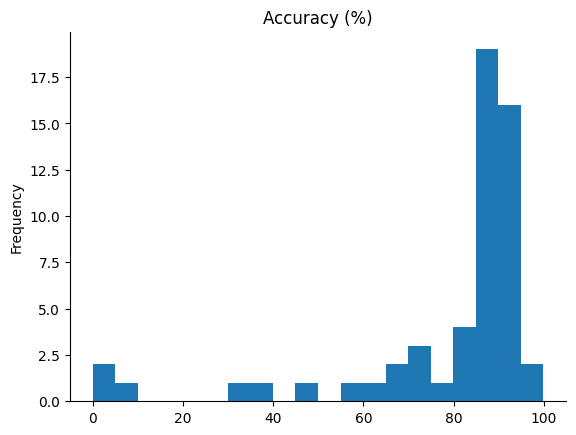

In [17]:
# @title Accuracy (%)

from matplotlib import pyplot as plt
accuracy_df['Accuracy (%)'].plot(kind='hist', bins=20, title='Accuracy (%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

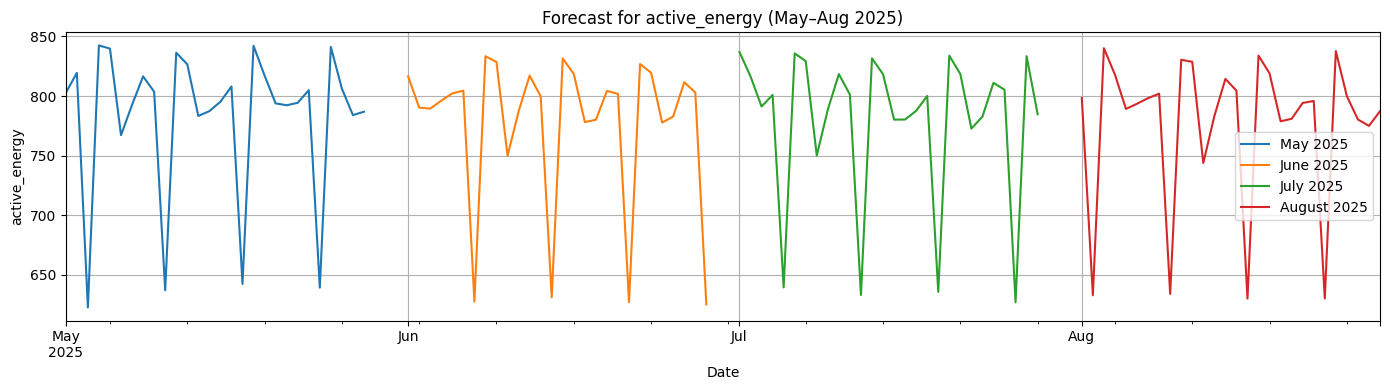

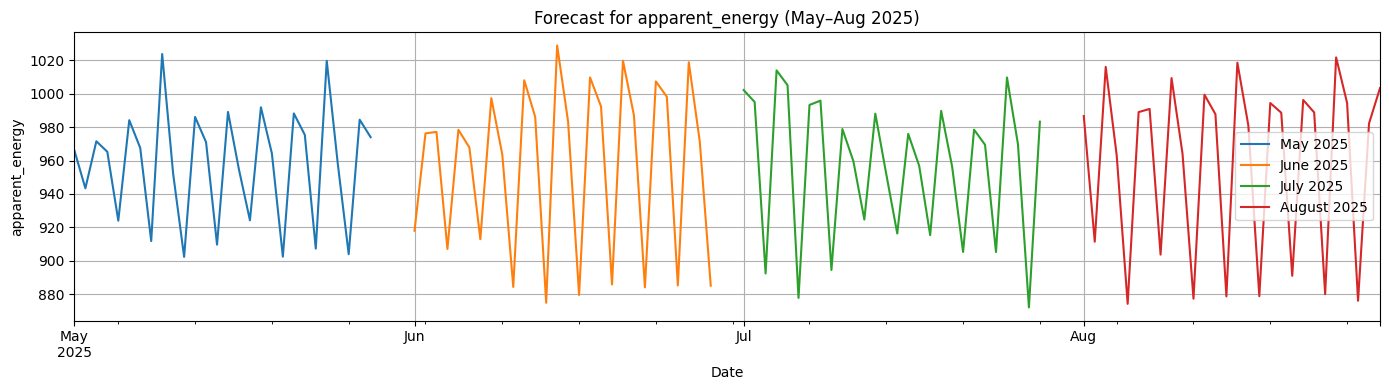

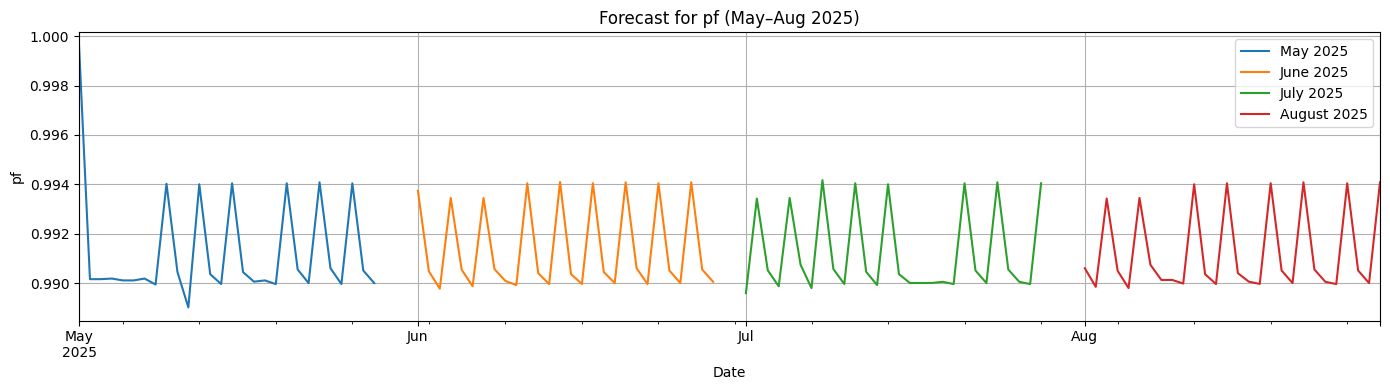

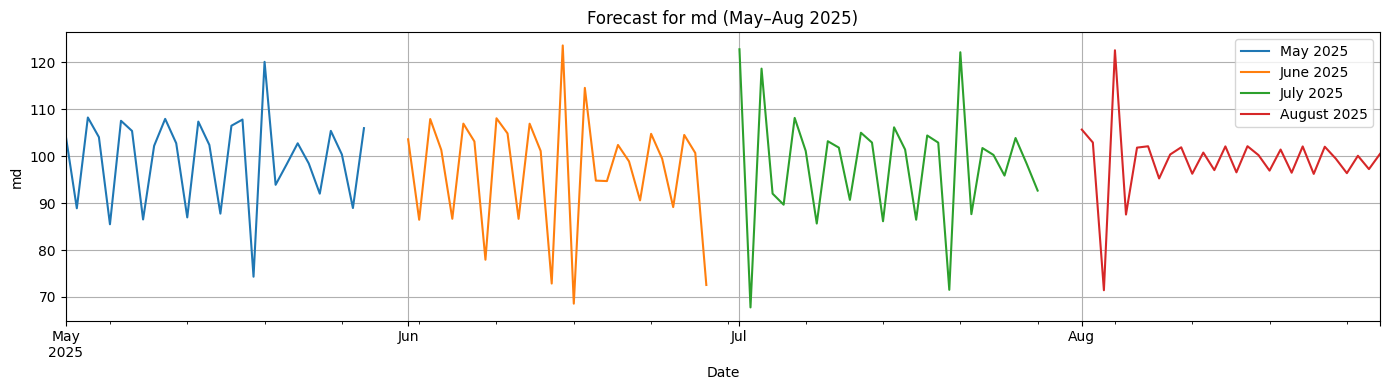

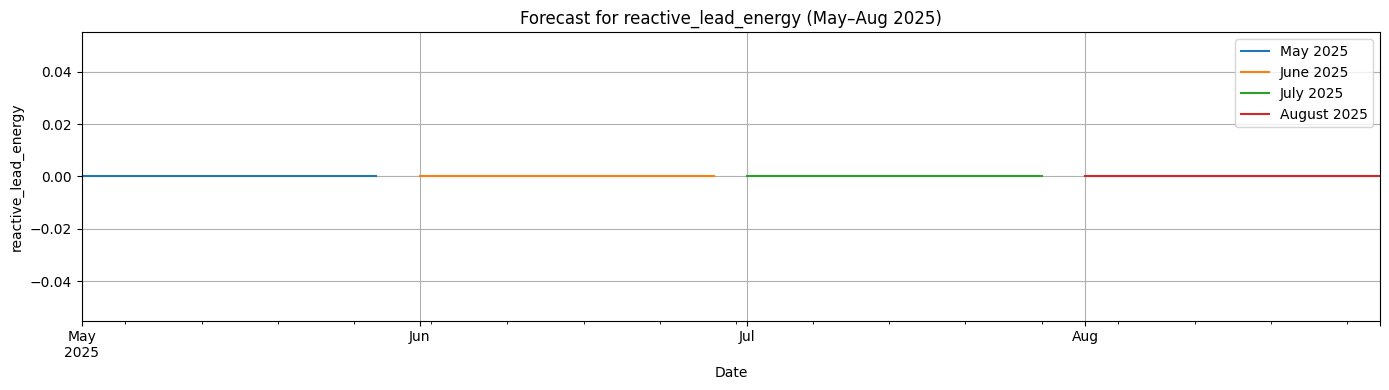

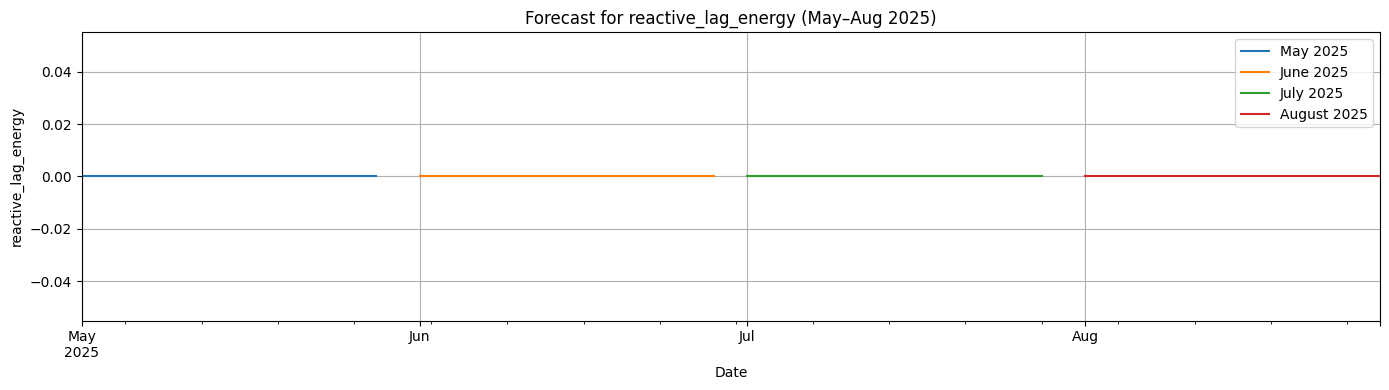

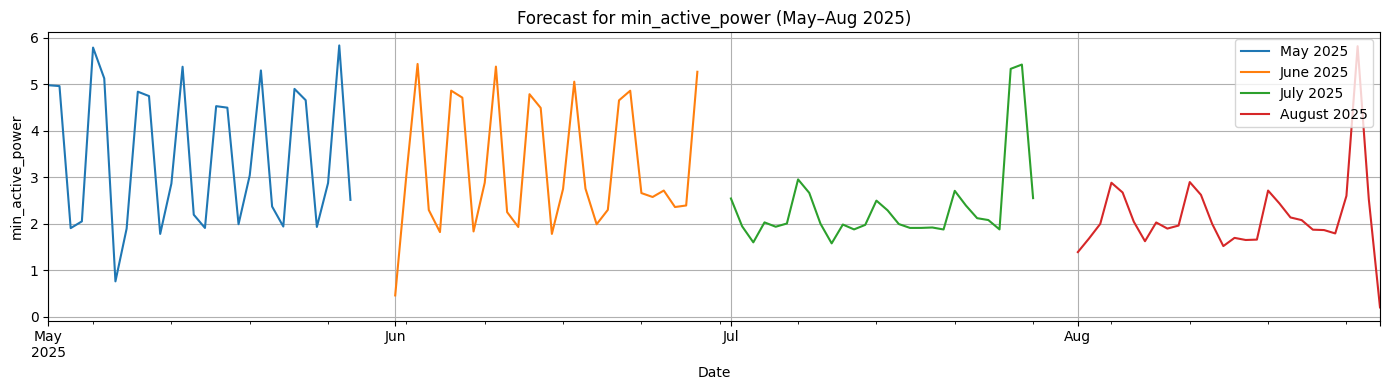

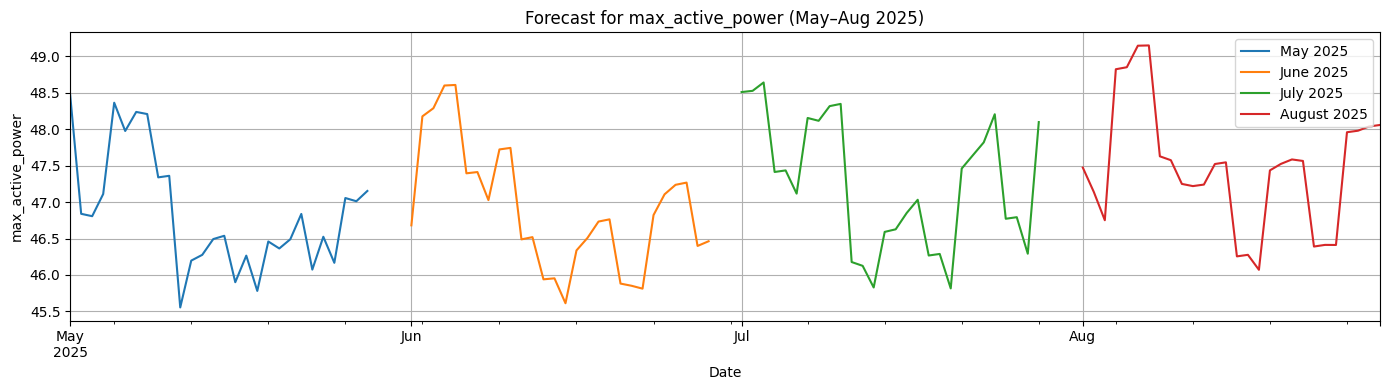

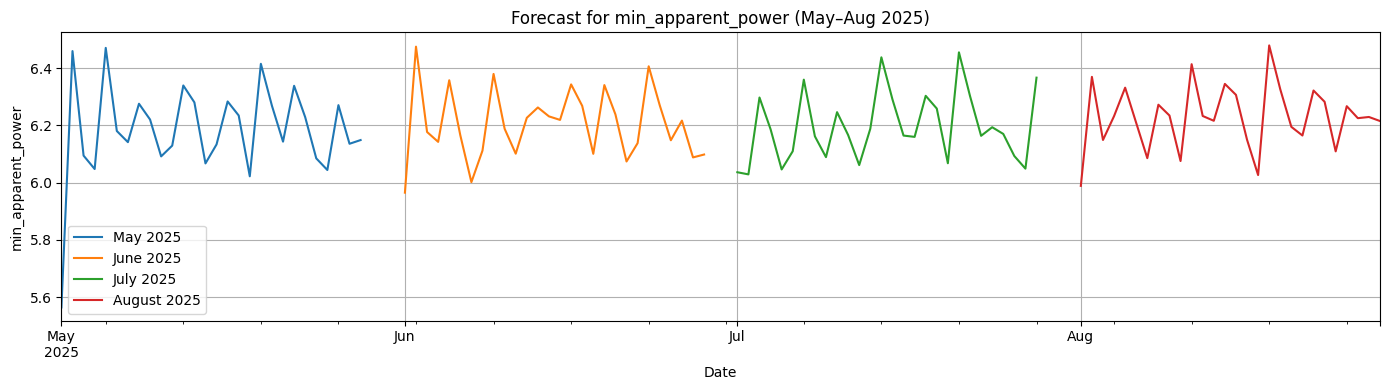

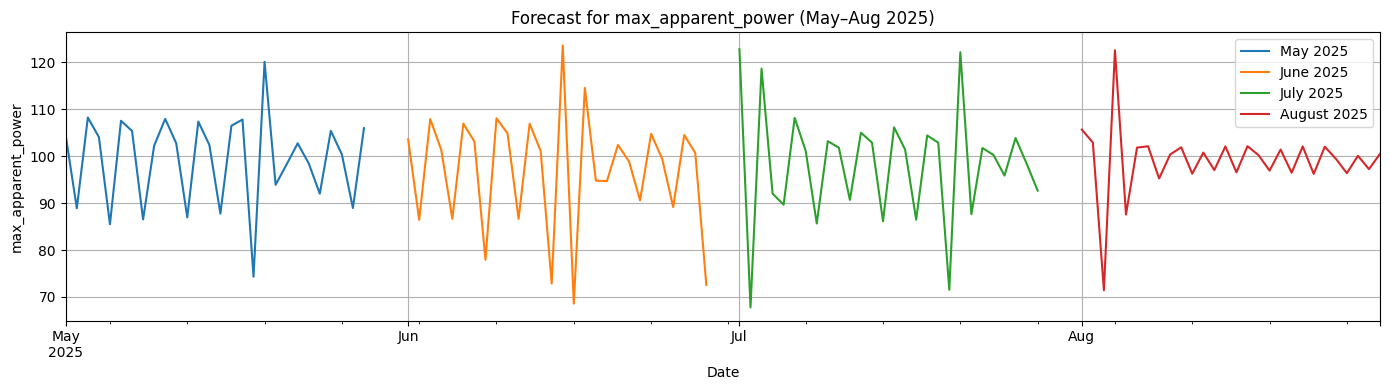

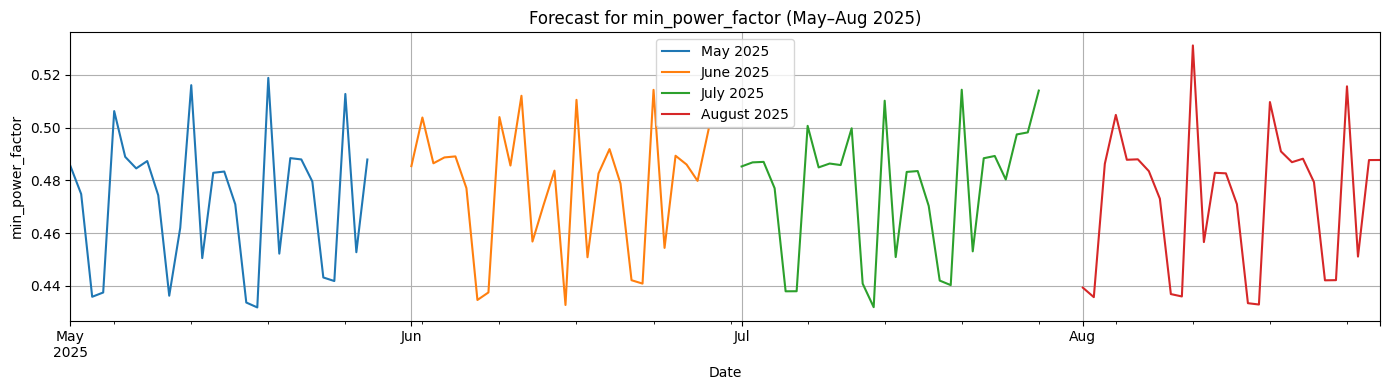

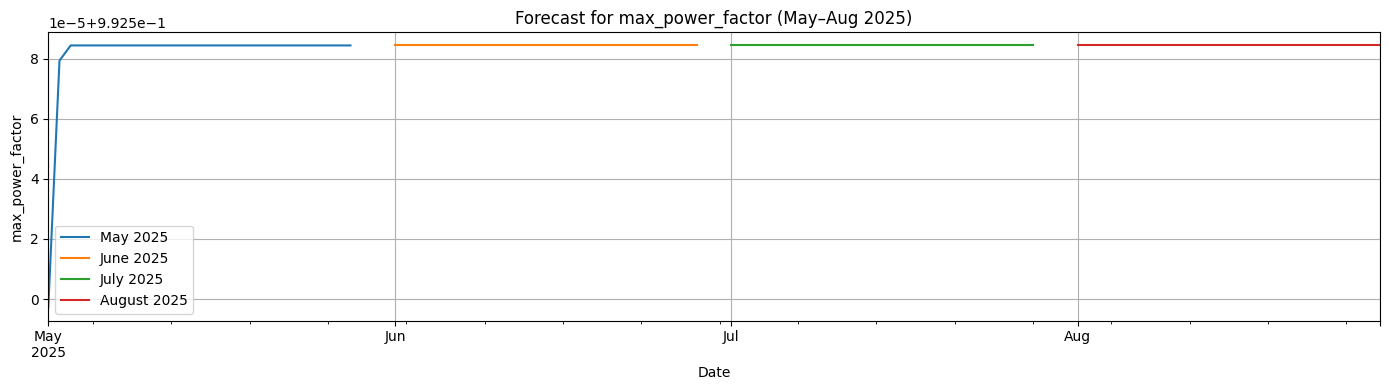

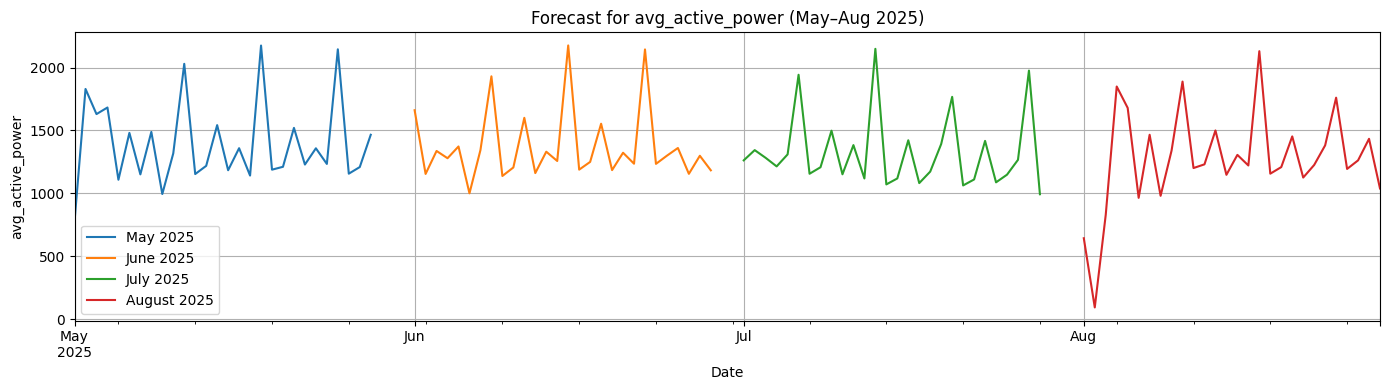

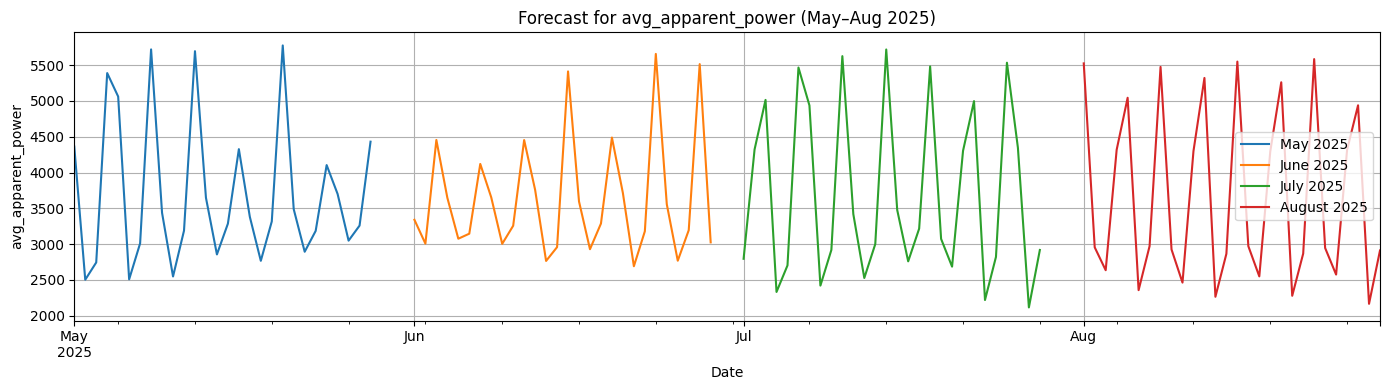

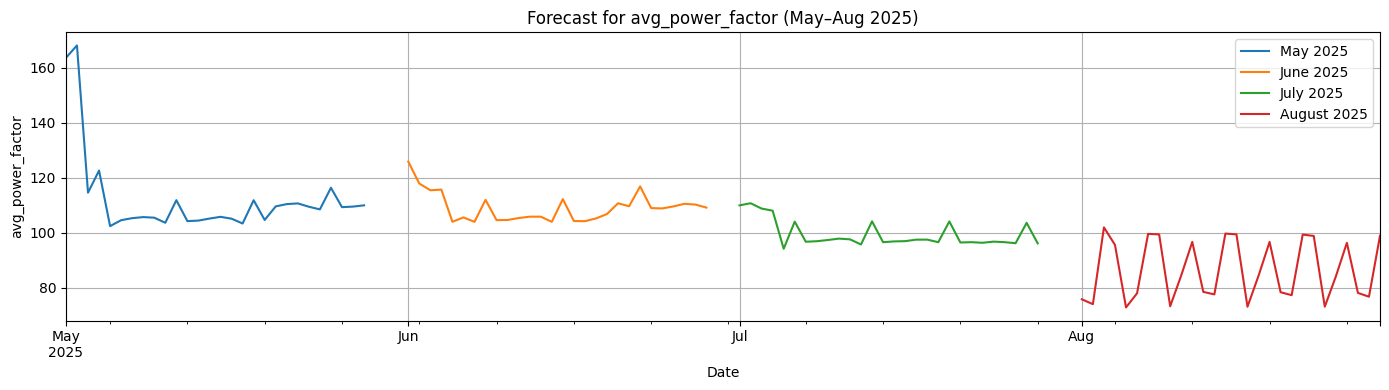

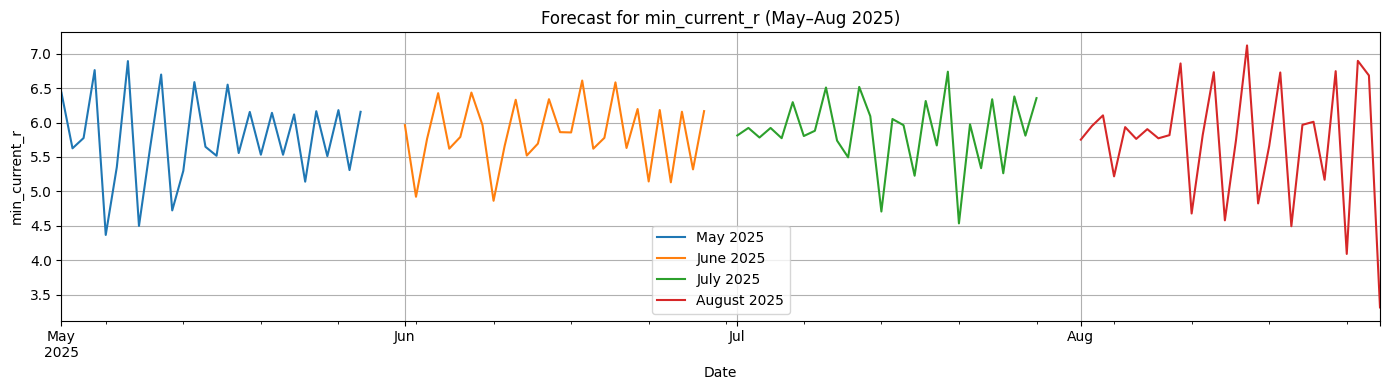

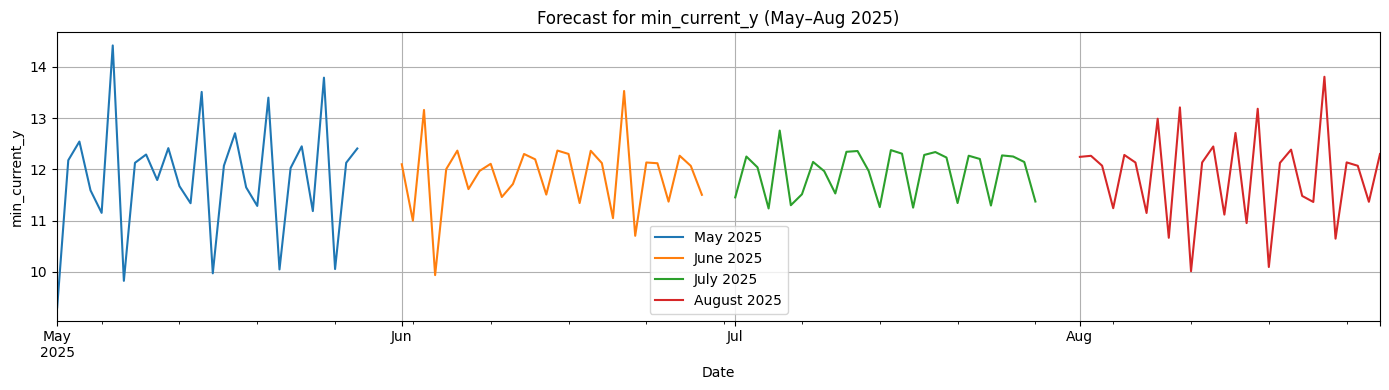

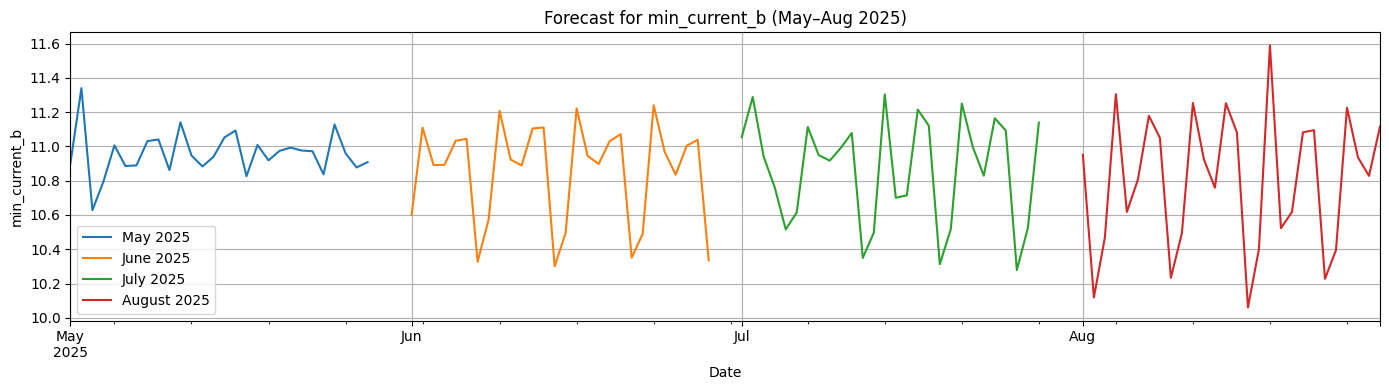

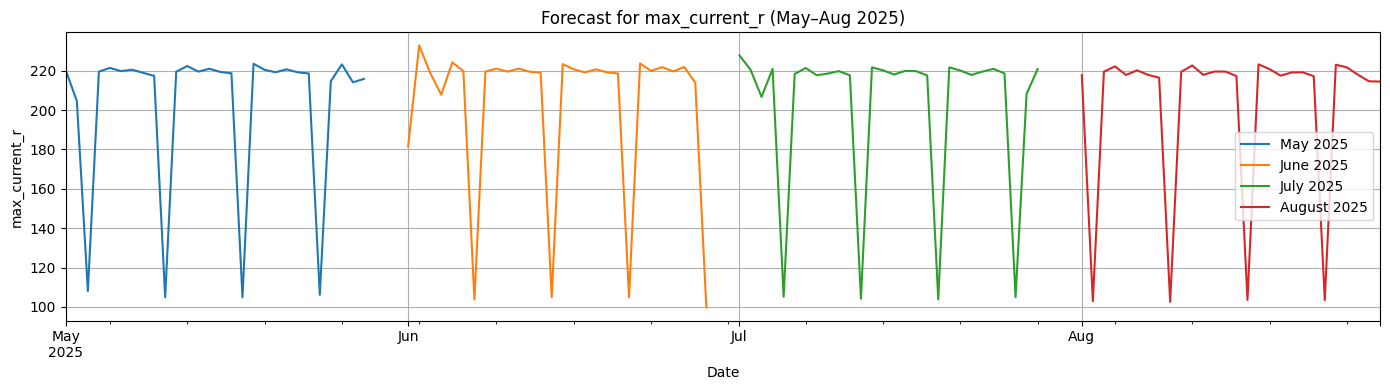

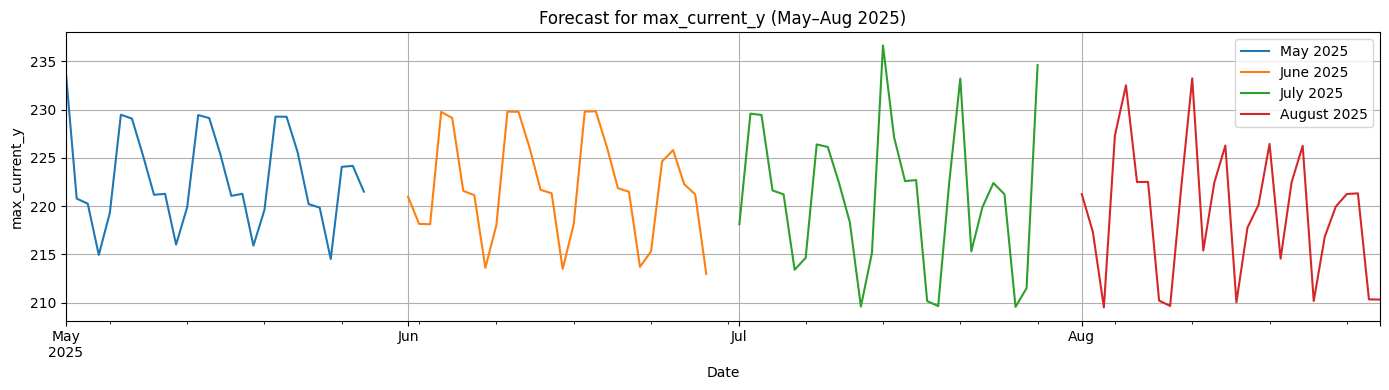

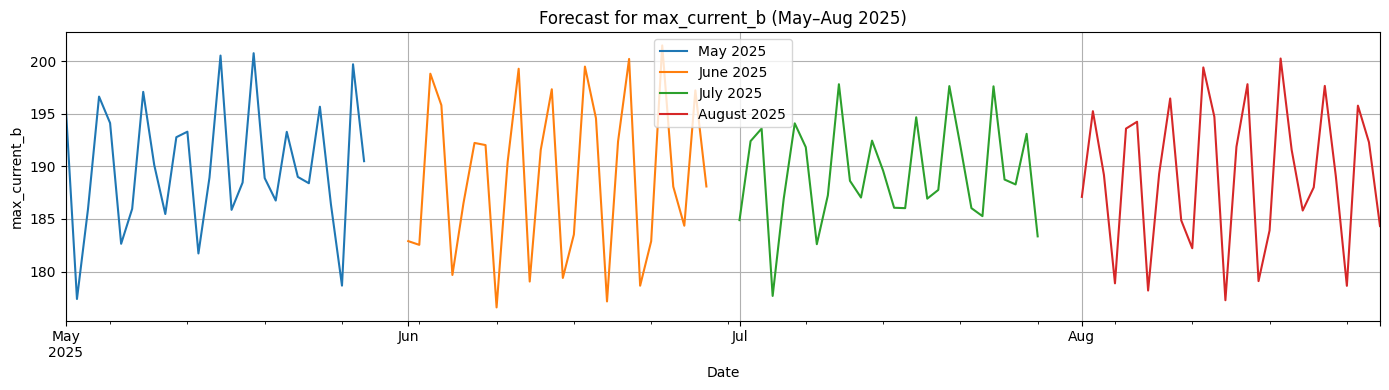

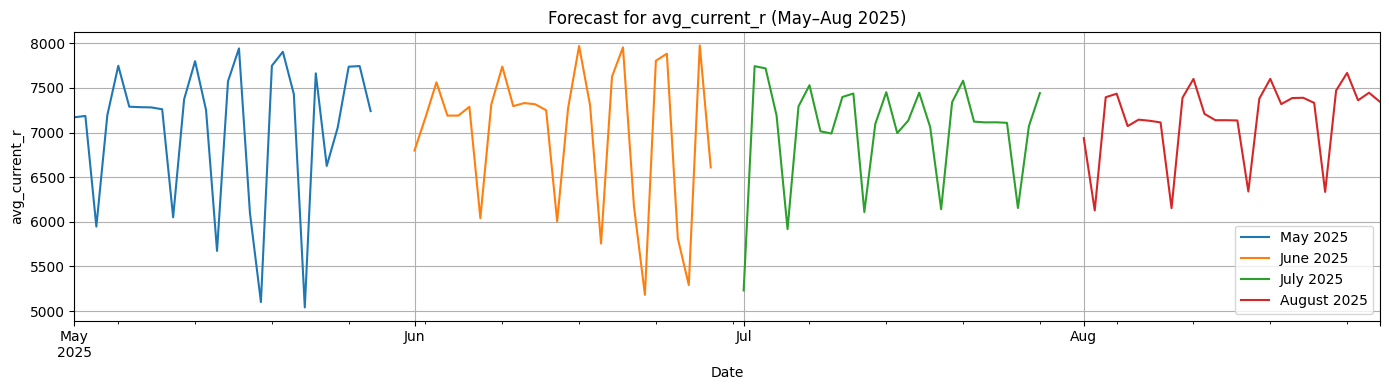

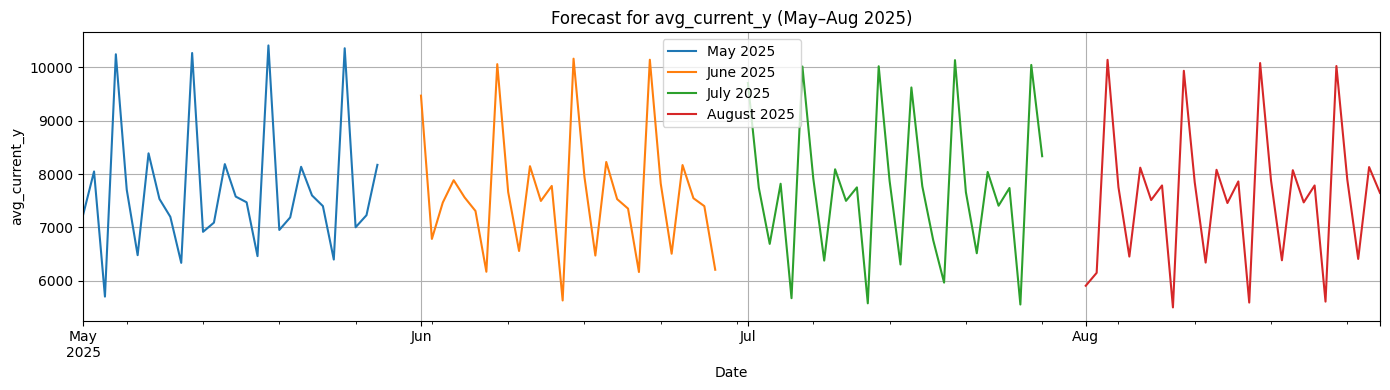

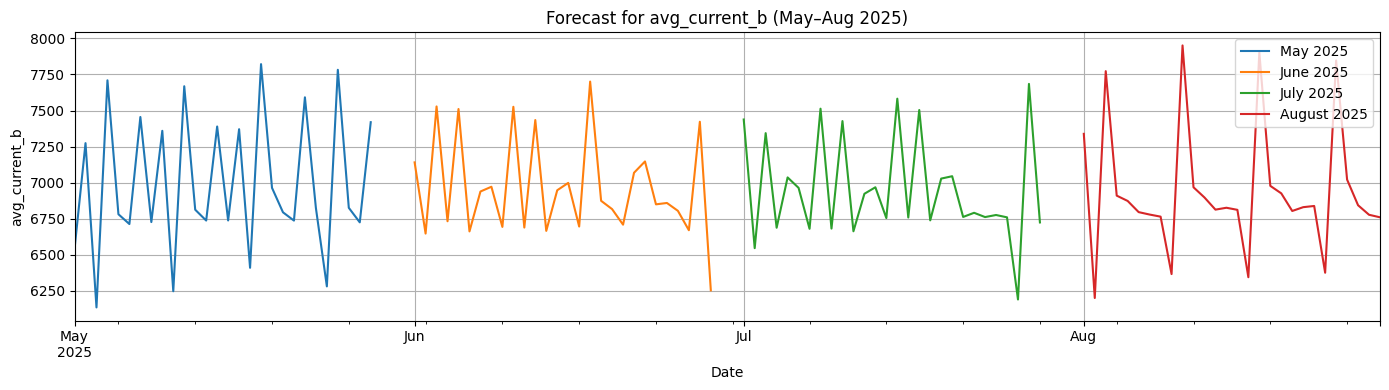

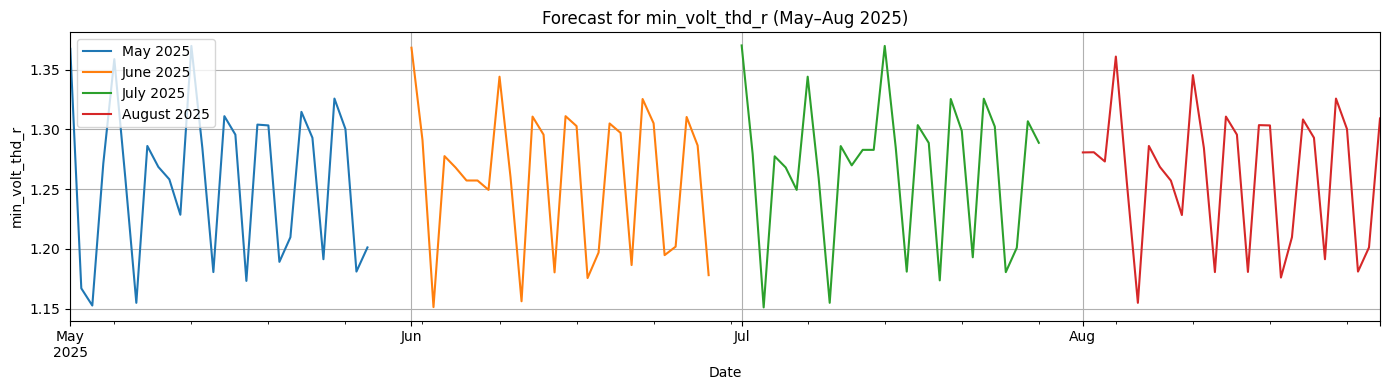

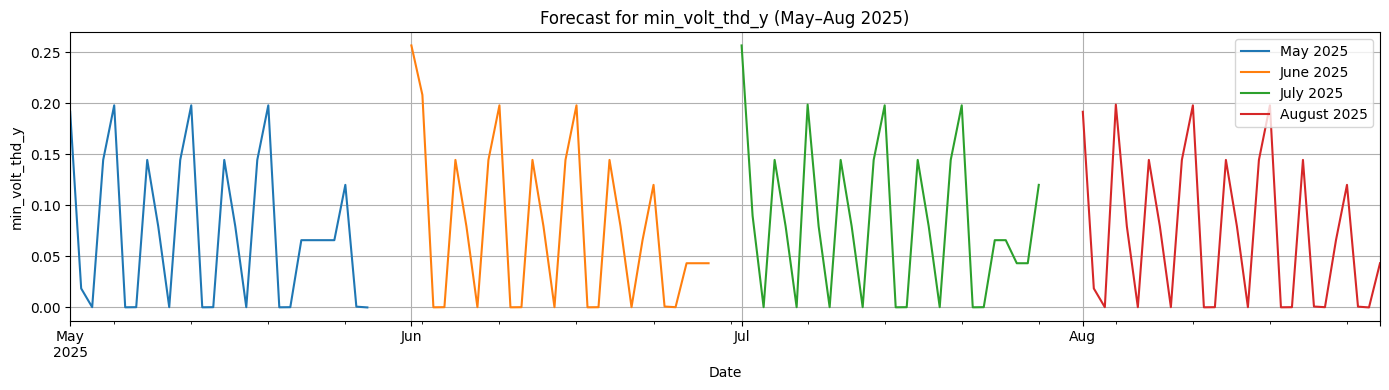

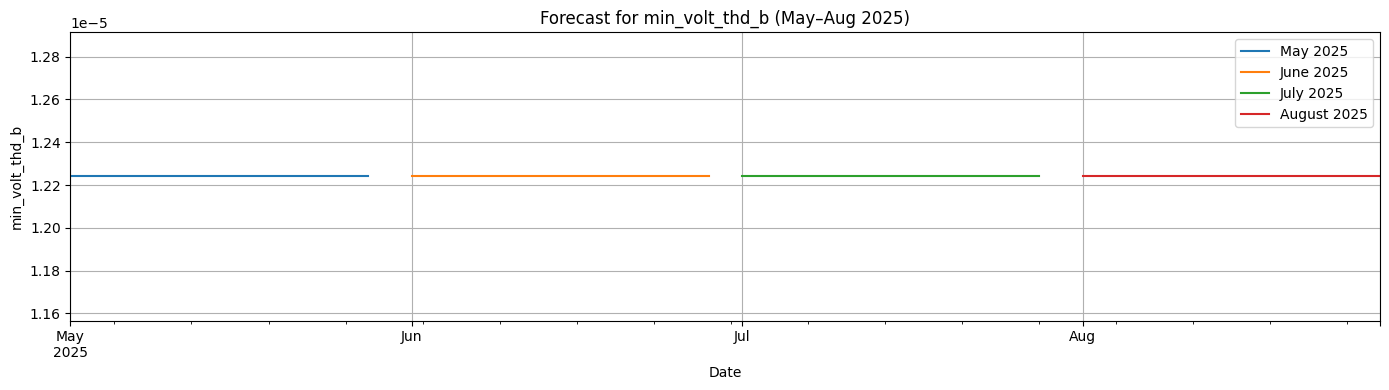

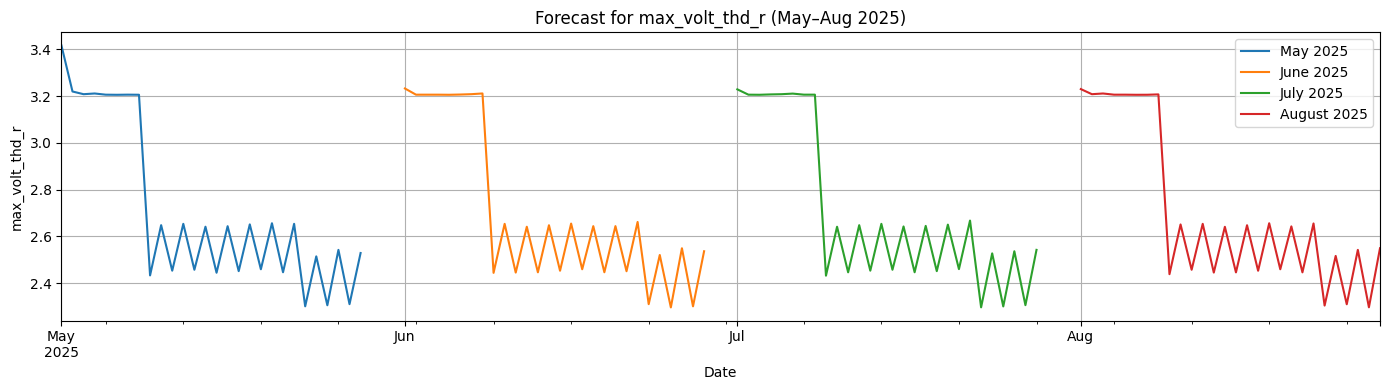

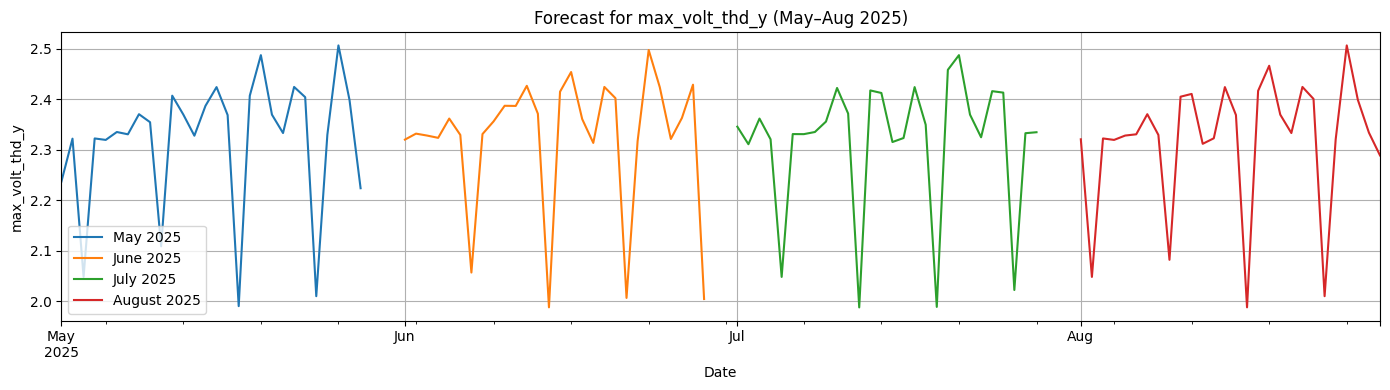

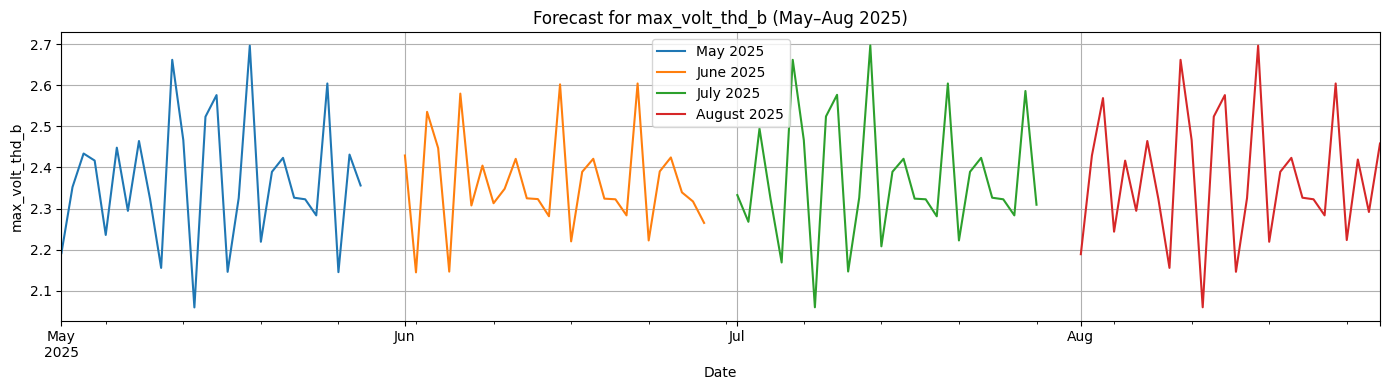

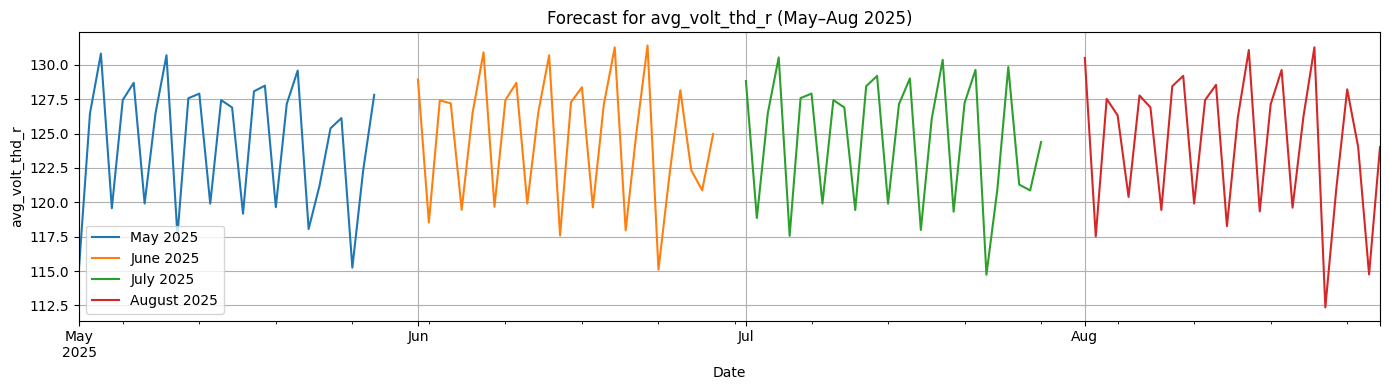

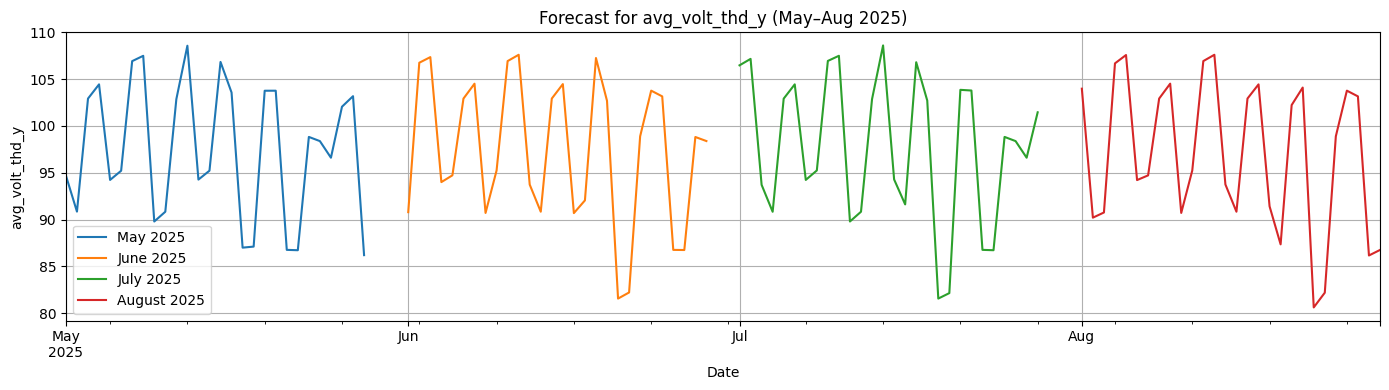

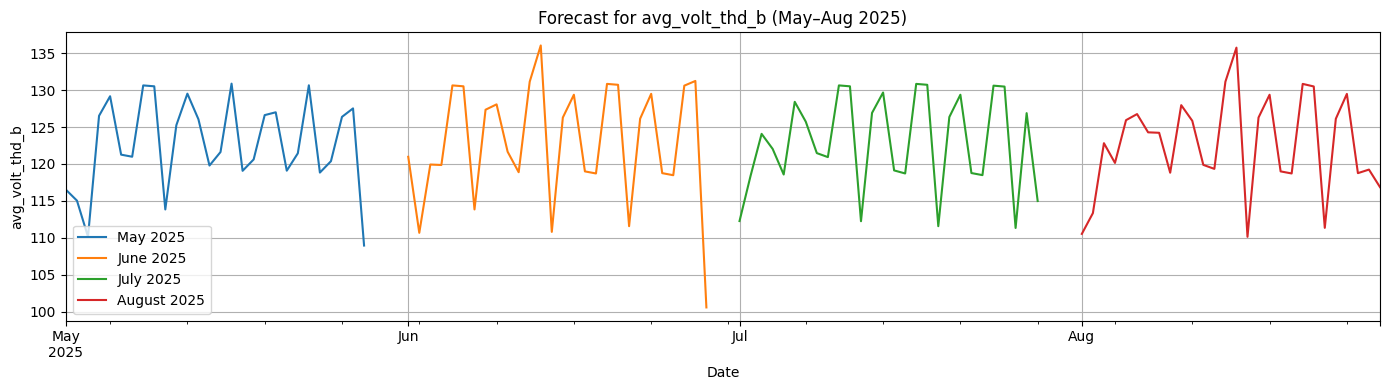

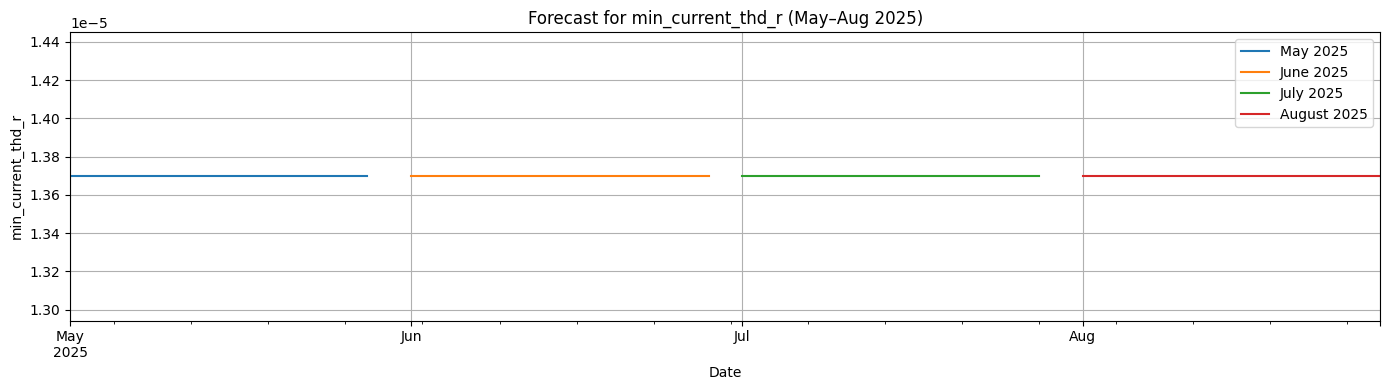

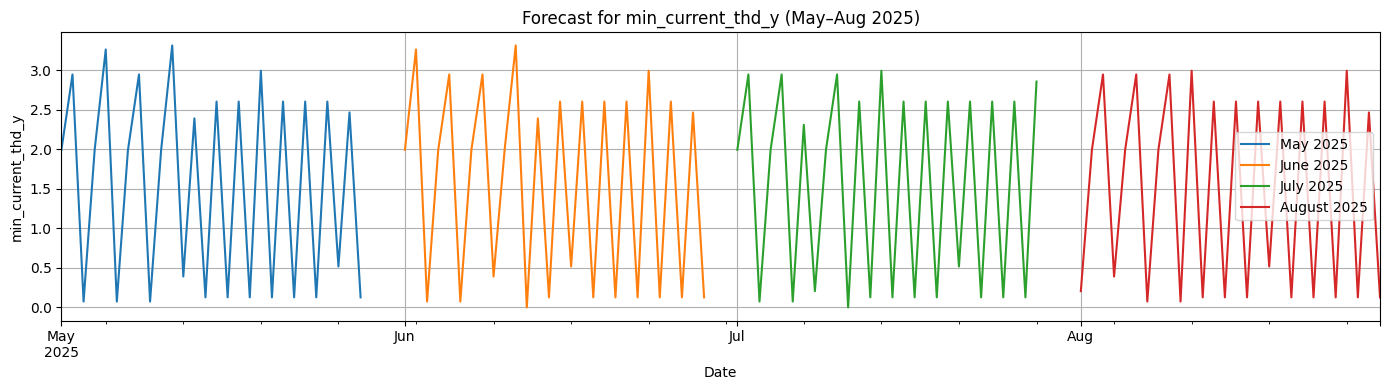

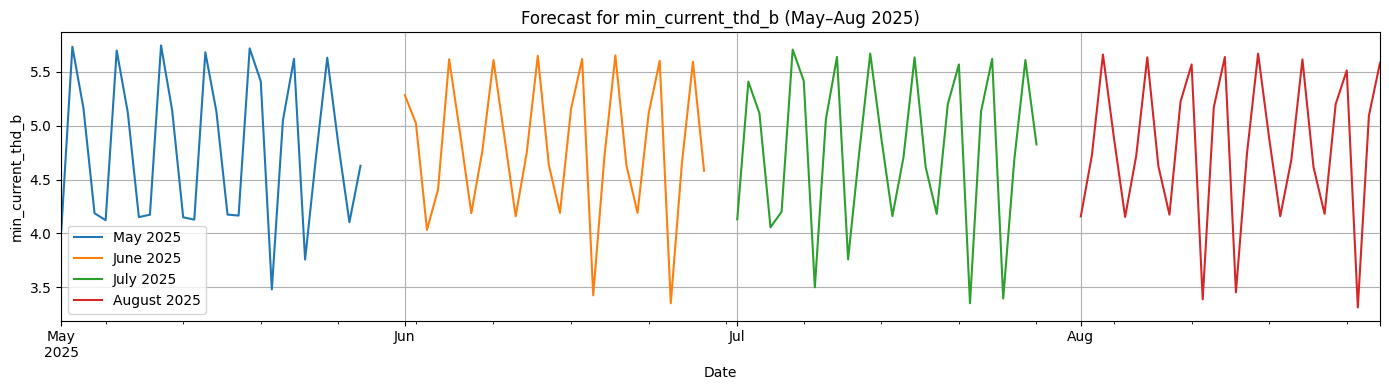

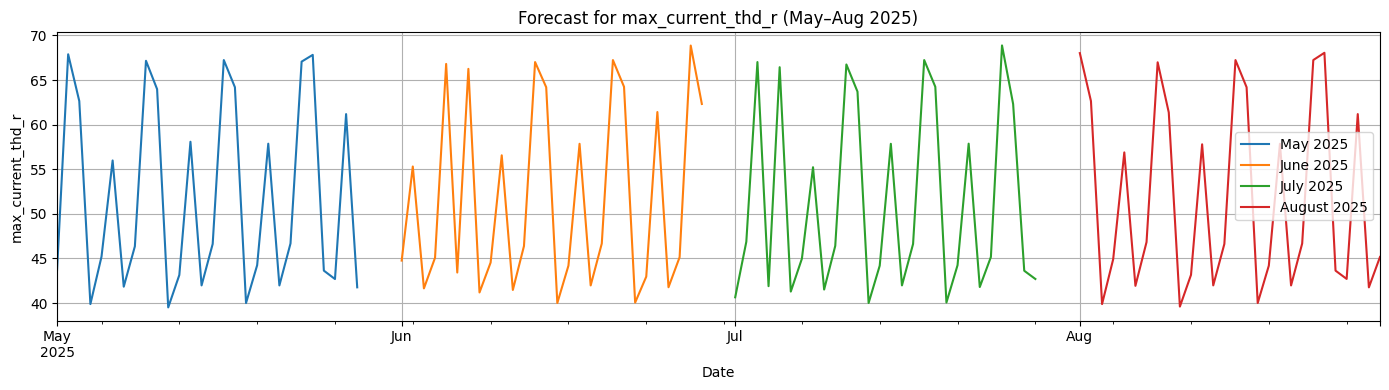

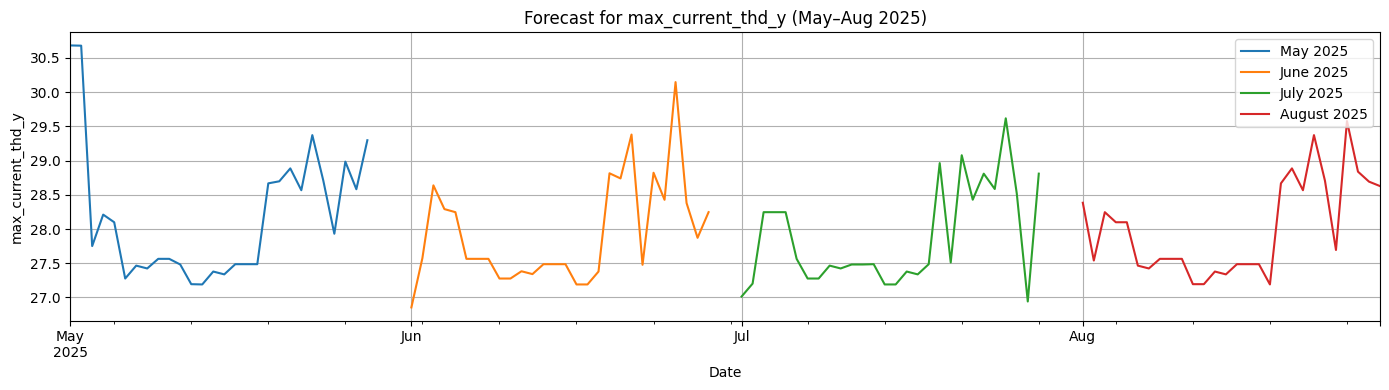

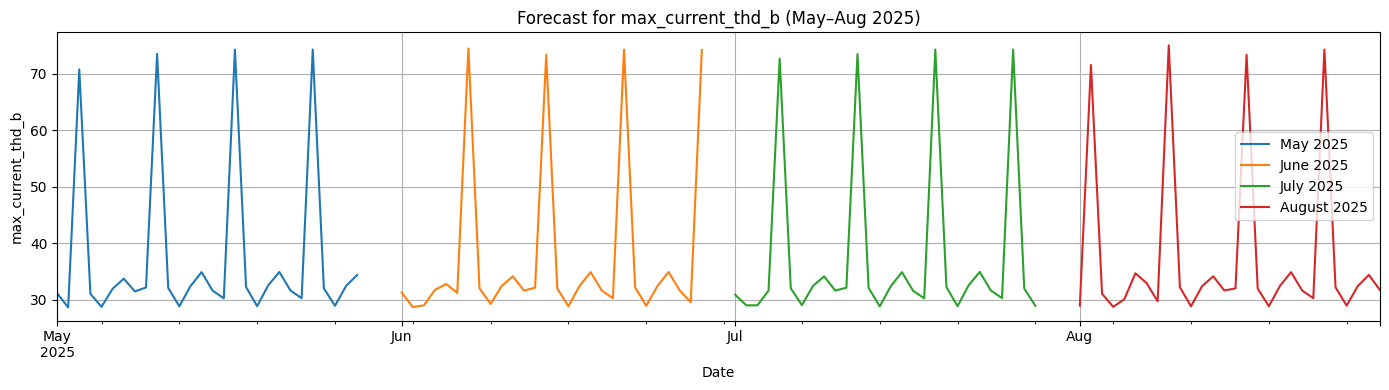

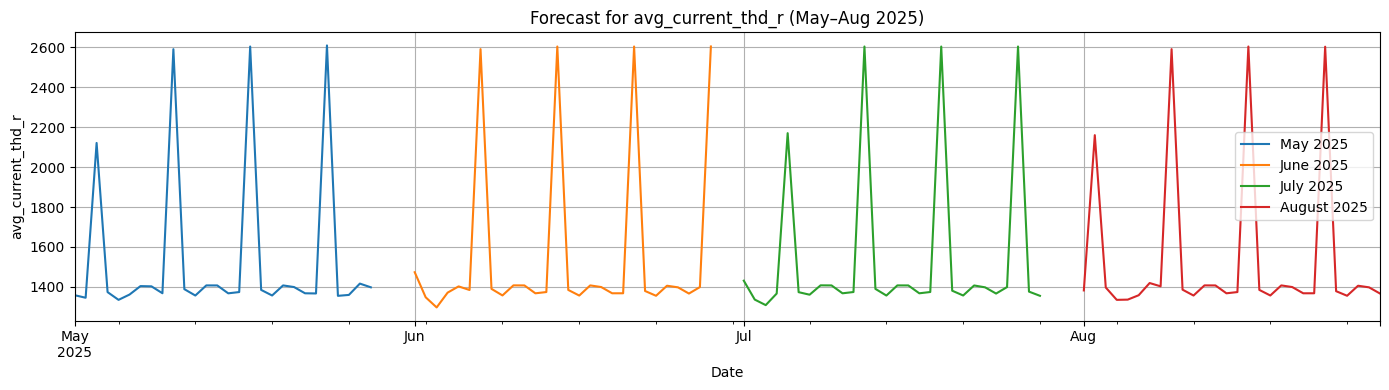

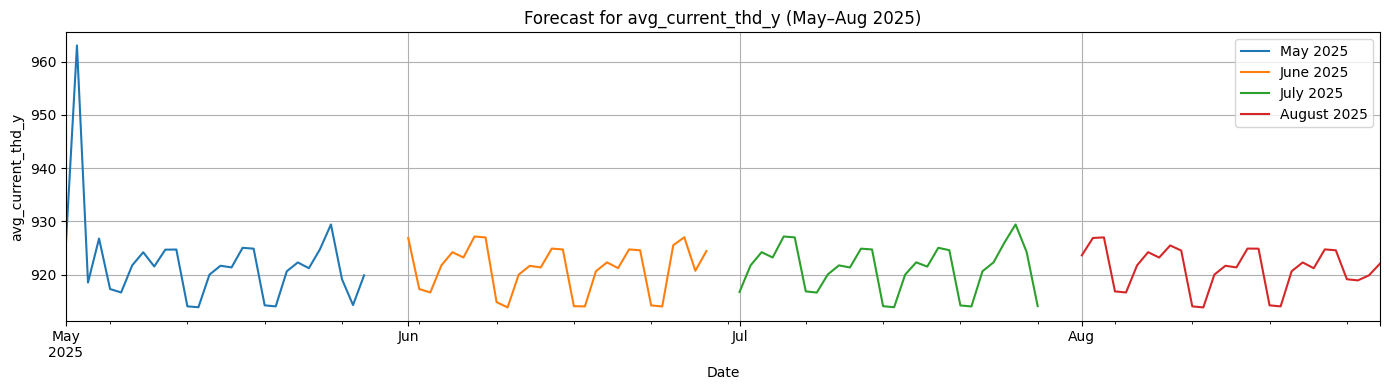

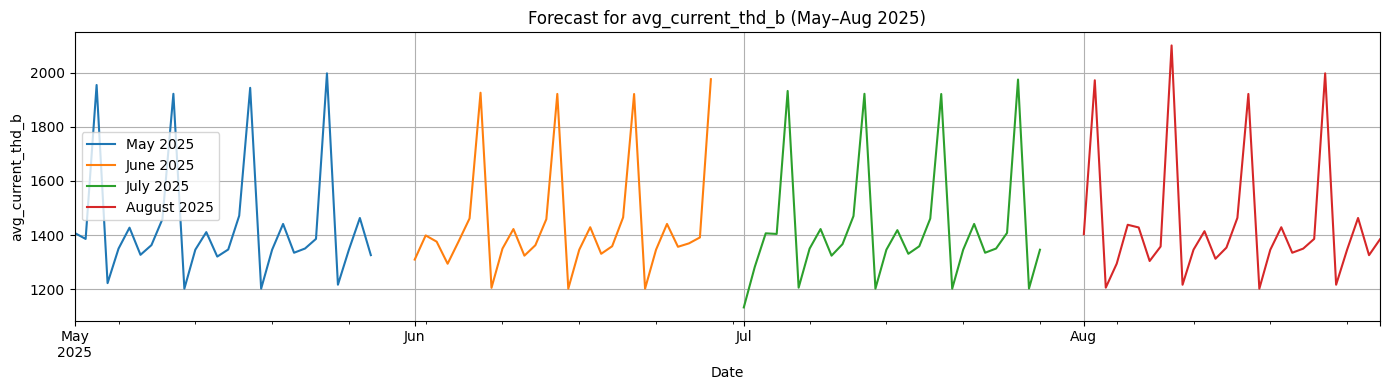

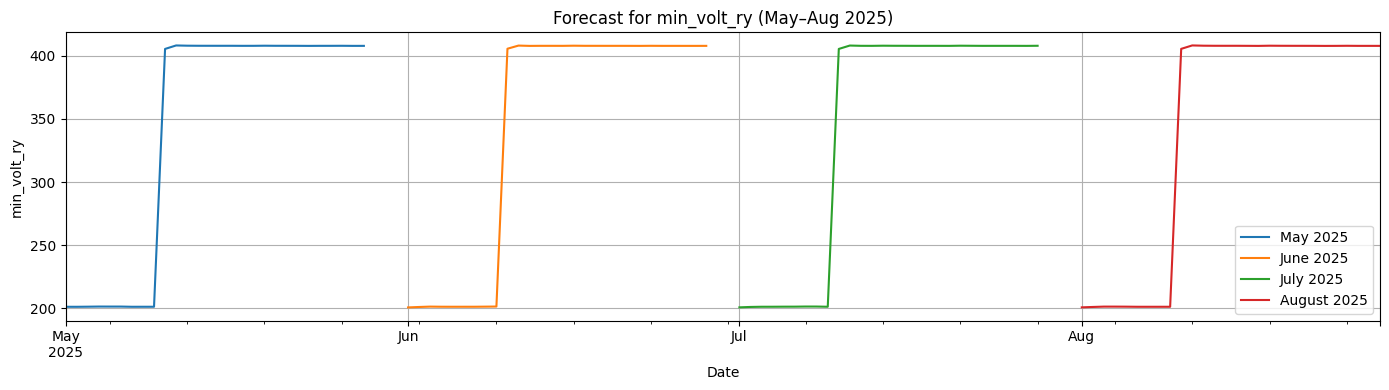

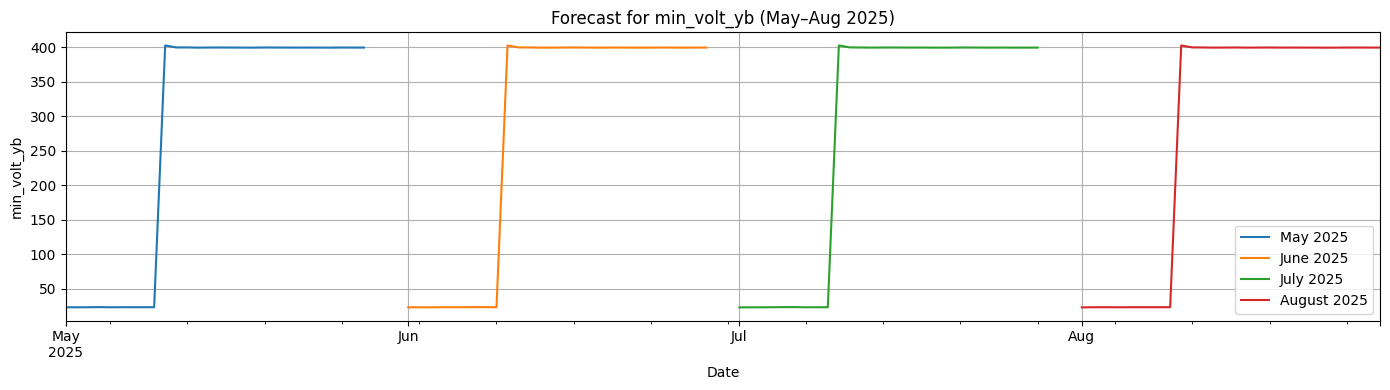

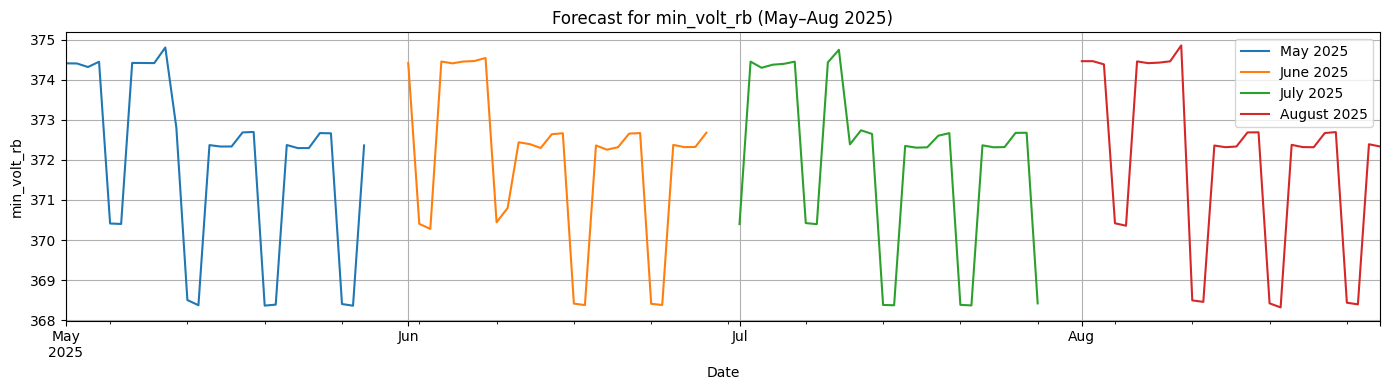

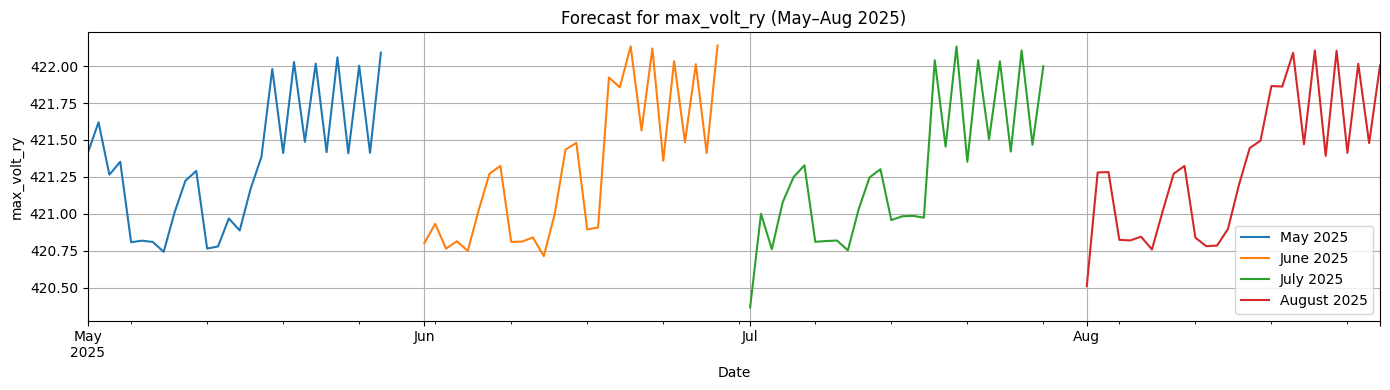

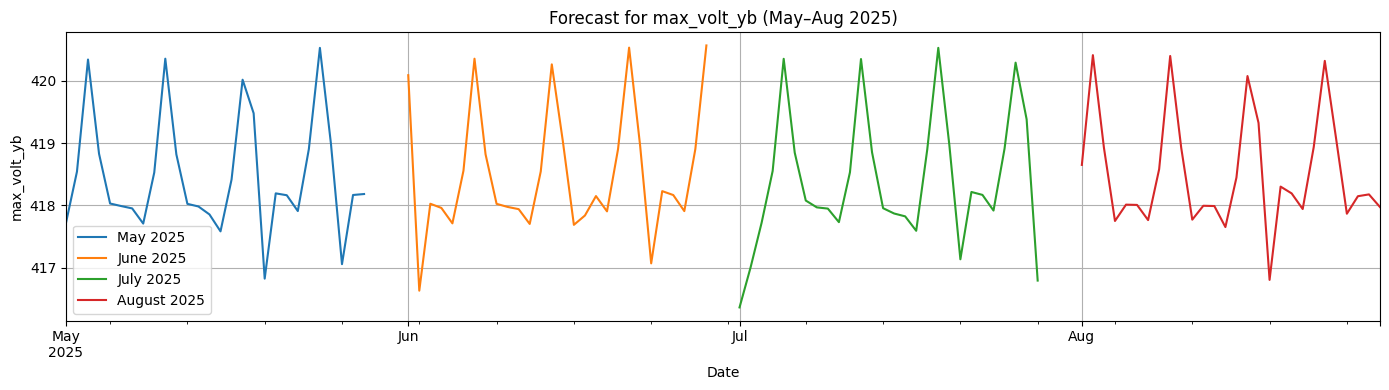

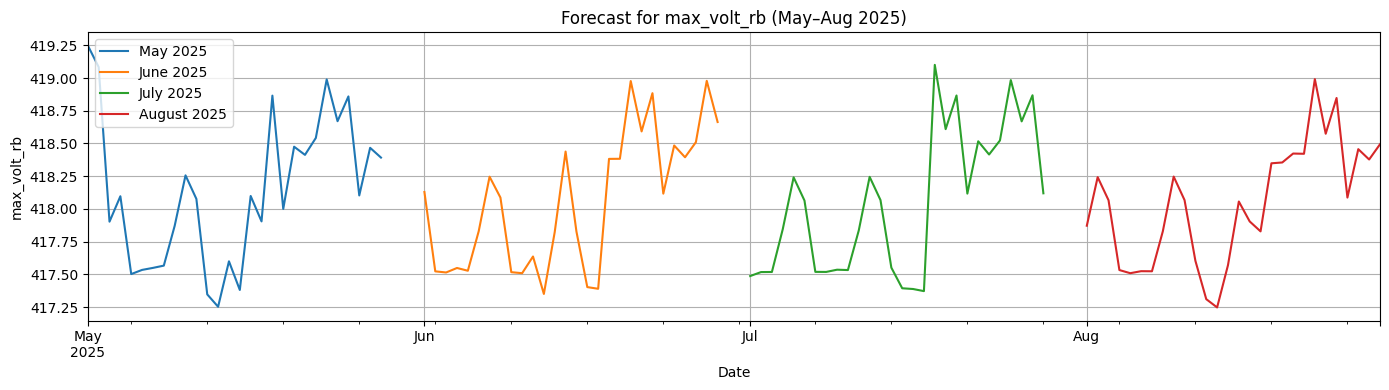

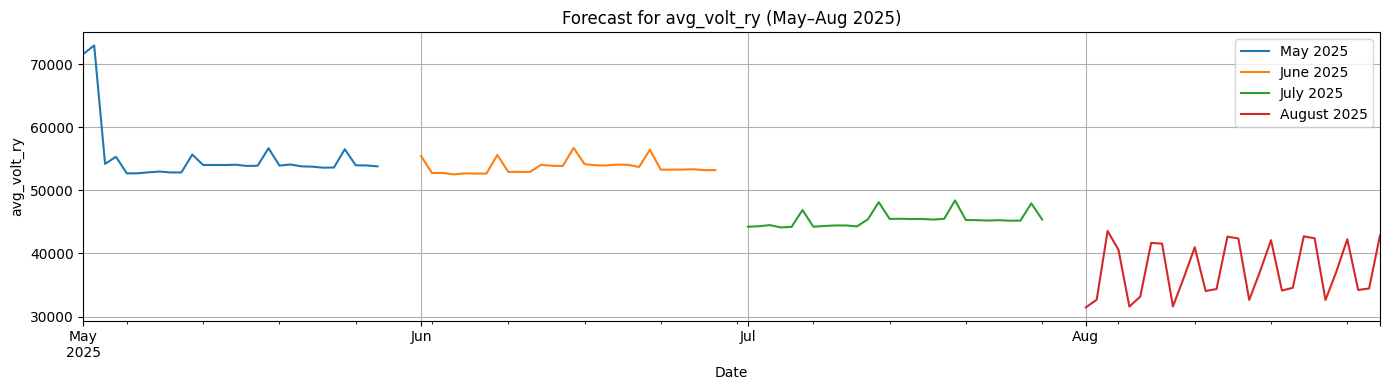

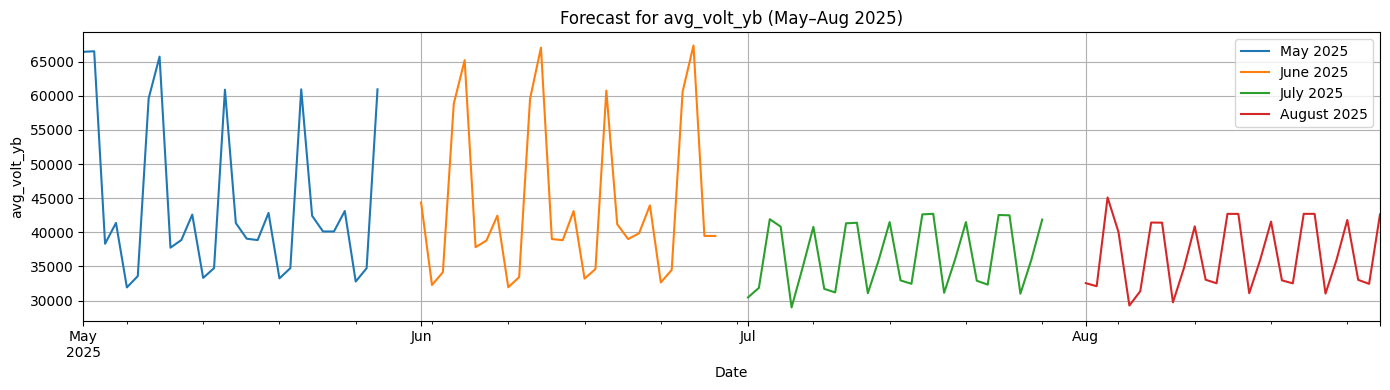

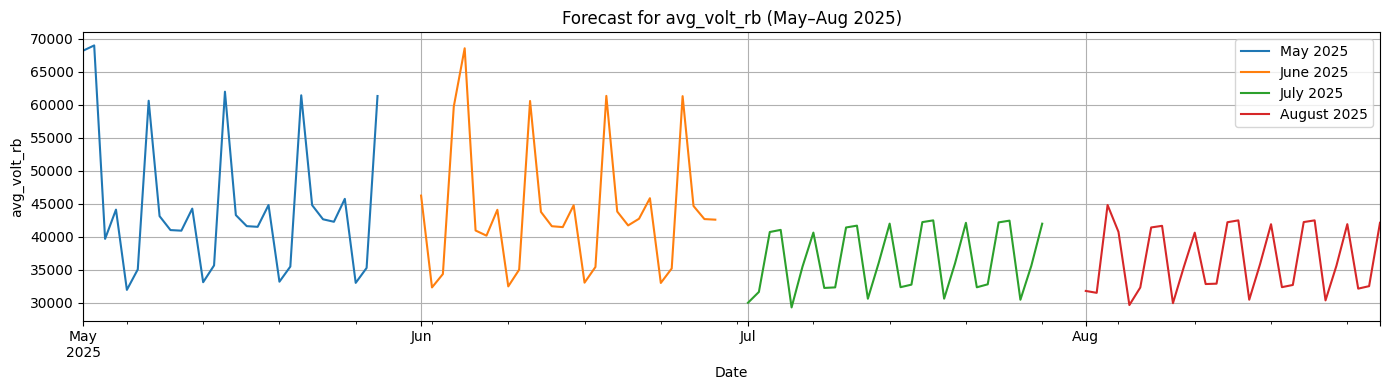

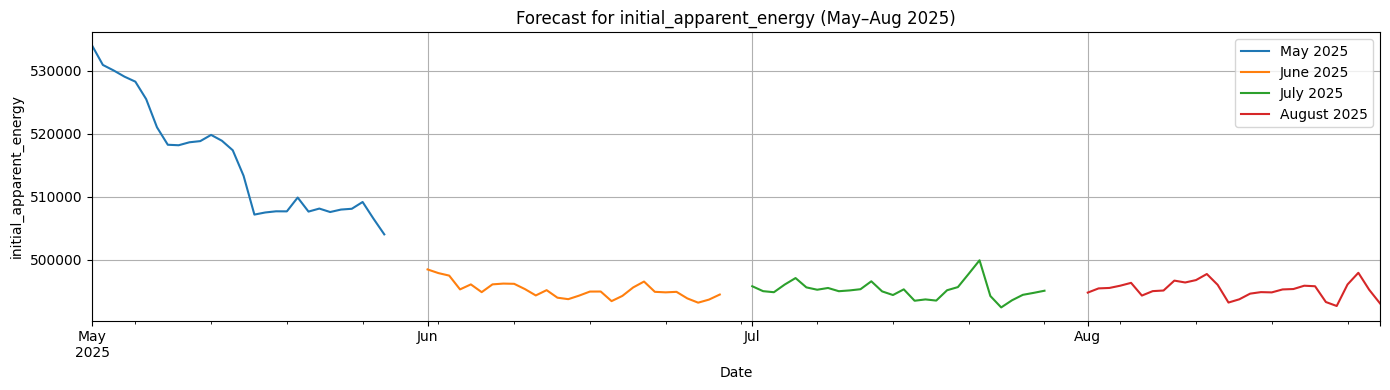

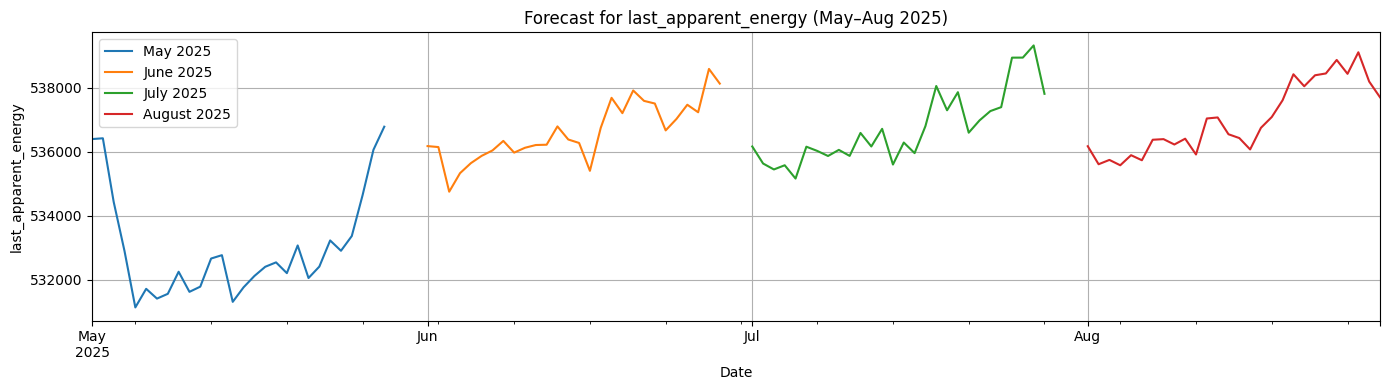

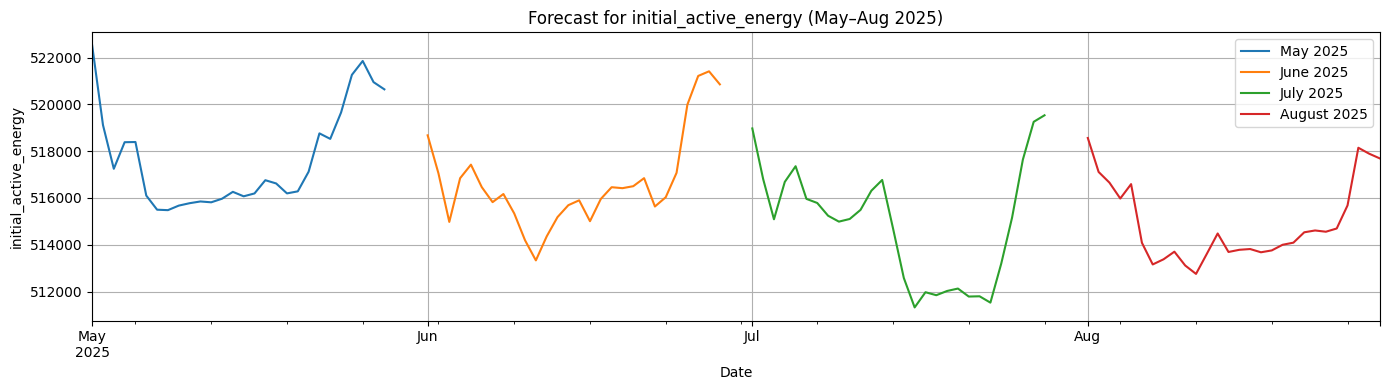

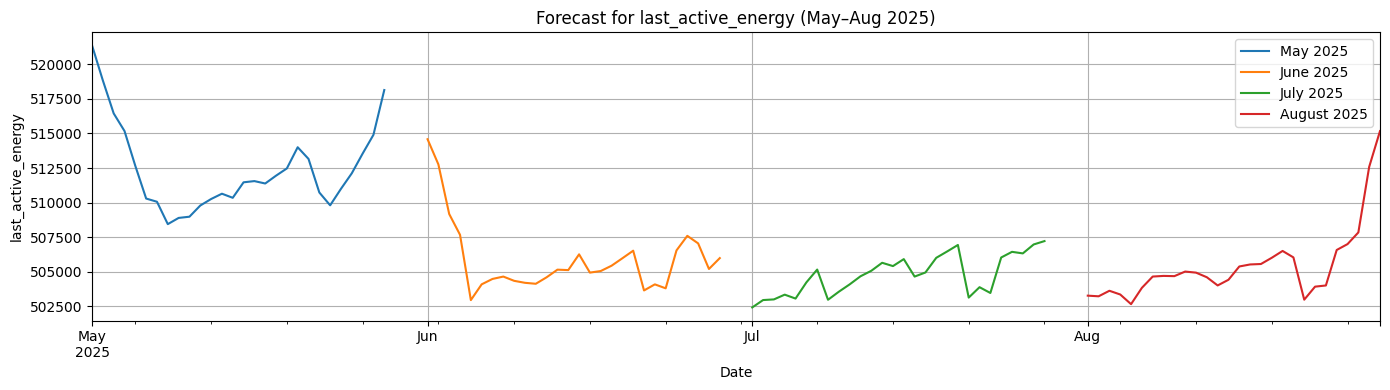

In [15]:
# PLOTS
import matplotlib.pyplot as plt
for target in target_columns:
    plt.figure(figsize=(14,4))
    for month in ['May', 'June', 'July', 'August']:
        results[target][month].plot(label=f'{month} 2025')
    plt.title(f'Forecast for {target} (May–Aug 2025)')
    plt.ylabel(target)
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [16]:
# EXPORT: SIDE-BY-SIDE FORMAT
final_rows = []
for target in target_columns:
    before_data = df.loc["2025-01-01":"2025-04-30", target]
    after_data = pd.concat([results[target][m] for m in ['May', 'June', 'July', 'August']])

    before_dates = before_data.index[:len(after_data)]
    after_dates = after_data.index[:len(before_data)]

    for bd, ad, bv, av in zip(before_dates, after_dates, before_data.values, after_data.values):
        final_rows.append({
            "Date Before Prediction": bd,
            "Date After Prediction": ad,
            "Before Target": target,
            "After Target": target,
            "Before Value": bv,
            "After Value": av,
            "Before Type": "before_prediction",
            "After Type": "after_prediction"
        })

aligned_df = pd.DataFrame(final_rows)
aligned_df.to_csv("Aligned_Predictions_With_Weekend_Holiday.csv", index=False)
print("✅ Saved: Aligned_Predictions_With_Weekend_Holiday.csv")

✅ Saved: Aligned_Predictions_With_Weekend_Holiday.csv
